# Exploration of MobileNetV3 Architecture and it's Robustness:
#### Yassin Bahid

After the success of the first and second iterations pg MobileNet, A.Howard moved to try and find the optimal MobileNet Architechture. This change signals a shift from feature engineering to architechture engineering. We shall explore this architechture and it's components, before shifting to testing it's robustness.


In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import Tensor
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import transforms, datasets, models
import time
from PIL import Image
import os.path

# 1 - MBNetV3 Construction:

## 1.1 - Blocks:

### 1.1.1 - Helping Functions:


In [21]:
def _ensure_divisible(number, divisor, min_value=None):
    '''
    Ensure that 'number' can be 'divisor' divisible
    Reference from original tensorflow repo:
    https://github.com/tensorflow/models/blob/master/research/slim/nets/mobilenet/mobilenet.py
    '''
    if min_value is None:
        min_value = divisor
    new_num = max(min_value, int(number + divisor / 2) // divisor * divisor)
    if new_num < 0.9 * number:
        new_num += divisor
    return new_num
    

#### Hard Sigmoid:
A modified sigmoid function of the form:

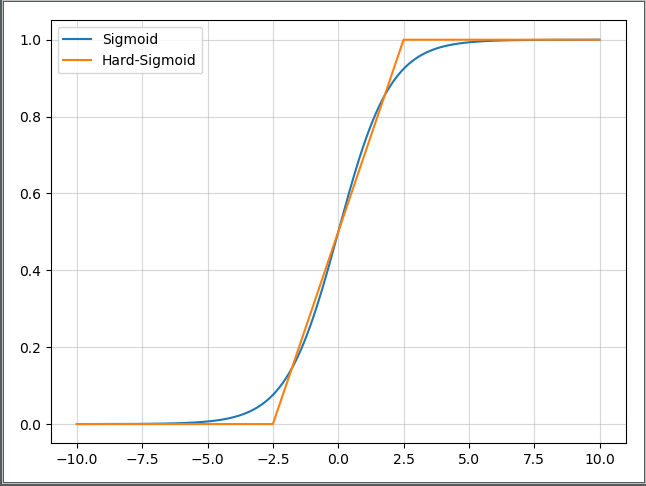

#### H Swish Function:
A modified Relu function that ensures the update of certain neurons. This function uses Relu6 which miics the behavior of the Sigmoid function while not being as expansive to compute/
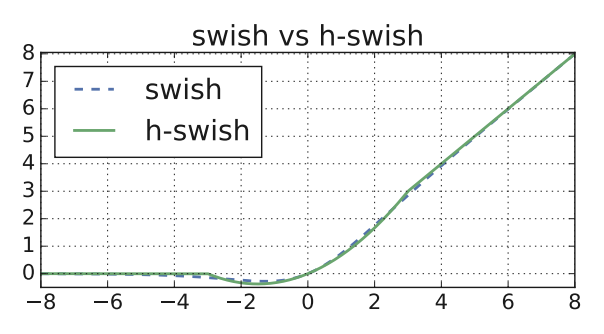

In [23]:
class H_swish(nn.Module):
    '''
    hard swish
    '''
    def __init__(self, inplace=True):
        super(H_swish, self).__init__()
        self.inplace = inplace

    def forward(self, x):
        return x * F.relu6(x + 3, inplace=self.inplace) / 6

### 1.1.1 - Convolutional Block:

In [13]:
class ConvBlock(nn.Module):
    # Convolution Block with Conv2d layer, Batch Normalization and ReLU. Act is an activation function. 
    def __init__(
                        self,
                        in_channels : int,
                        out_channels : int,
                        kernel_size : int,
                        stride : int,
                        act = nn.ReLU(),
                        groups = 1,
                        bn = True, #Makes sure there is a pass through batch nomalization.
                        bias = False     
                        ):
        super().__init__()

        # If k = 1 -> p = 0, k = 3 -> p = 1, k = 5, p = 2. 
        padding = kernel_size // 2 
        self.c = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding, groups=groups, bias=bias)
        self.bn = nn.BatchNorm2d(out_channels) if bn else nn.Identity()
        self.act = act

    def forward(self, x: Tensor) -> Tensor:
        return self.act(self.bn(self.c(x)))

### 1.1.2 - Squeeze and Excitation Block:

Squeeze and excitation block is an attention mechanism that points out the most important channels after a residual channel. 
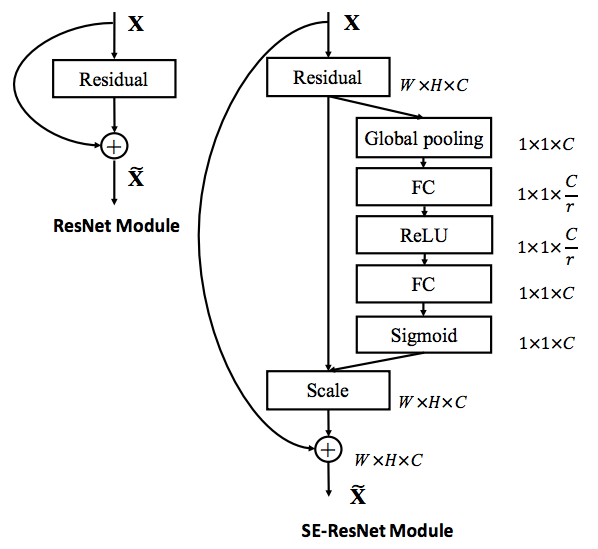

In [31]:
class SeBlock(nn.Module):
    # Squeeze and Excitation Block. 
    def __init__(
        self, 
        in_channels : int
        ):
        super().__init__()

        C = in_channels
        r = C // 4
        self.globpool = nn.AdaptiveAvgPool2d((1,1))
        self.fc1 = nn.Linear(C, r, bias=False)
        self.fc2 = nn.Linear(r, C, bias=False)
        self.relu = nn.ReLU() 
        self.hsigmoid = nn.Hardsigmoid()

    def forward(self, x: Tensor) -> Tensor:
        # x shape: [N, C, H, W].  
        f = self.globpool(x)
        f = torch.flatten(f,1)
        f = self.relu(self.fc1(f))
        f = self.hsigmoid(self.fc2(f))
        f = f[:,:,None,None]
        # f shape: [N, C, 1, 1]  

        scale = x * f
        return scale

### 1.1.3 - BottleNeck:
A convolutional block consisting of a convolution, non linear functin to be determined, a deepwise convolution, and then a Squeezeand excitation if one does need to happen.

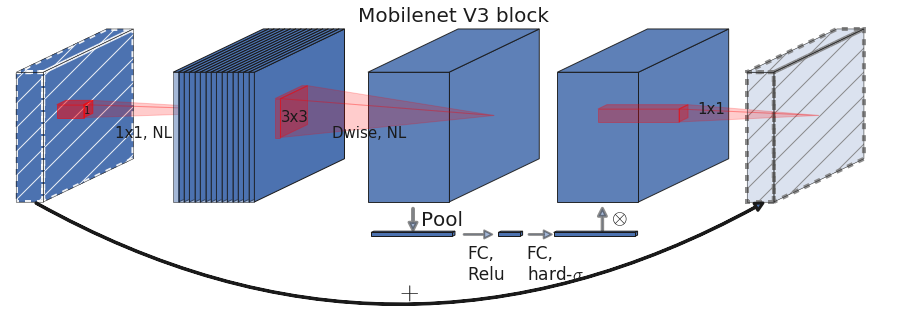

In [32]:
class BNeck(nn.Module):
    # MobileNetV3 Block 
    def __init__(
        self,
        in_channels : int,
        out_channels : int,
        kernel_size : int, 
        exp_size : int,
        se : bool, 
        act : torch.nn.modules.activation,
        stride : int
        ):
        super().__init__()

        self.add = in_channels == out_channels and stride == 1

        self.block = nn.Sequential(
            ConvBlock(in_channels, exp_size, 1, 1, act),
            ConvBlock(exp_size, exp_size, kernel_size, stride, act, exp_size),
            SeBlock(exp_size) if se == True else nn.Identity(),
            ConvBlock(exp_size, out_channels, 1, 1, act=nn.Identity())
        )

    def forward(self, x: Tensor) -> Tensor:
        res = self.block(x)
        if self.add:
            res = res + x

        return res

## 1.2 - Neural Architecture Search:

Equiped with these basic blocks, we are now ready to search for the optimal architechture. In order to do so, Howard used a Neural Search Architecture, where they fed a generated and trained model to a mobile phone checking for both accuracy and latency. The subsequent result is fed to the controller tasked of generating a new model.
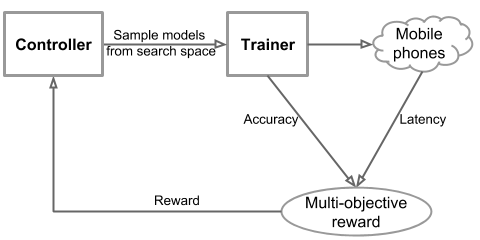

The controller is built as such and is used to optimize the number of layers:
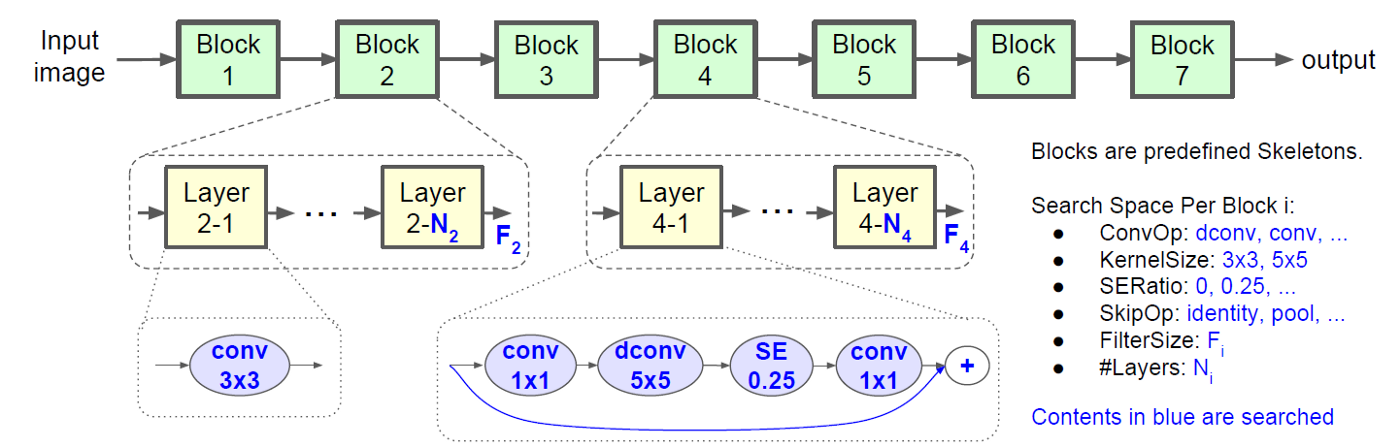
## 1.3 - Final Architechture:
The resulting architechture is: 

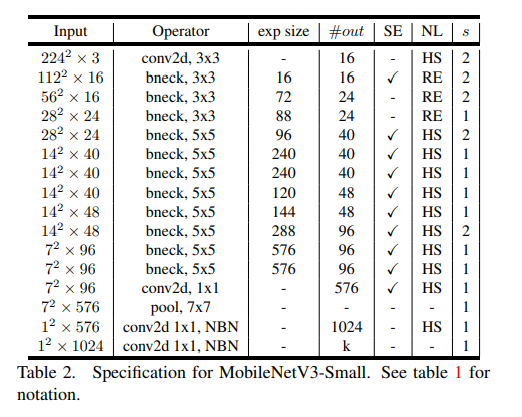
## 1.4 - Building The Model:

In [38]:
class MobileNetV3(nn.Module):
    def __init__(
        self,
        config_name : str,
        in_channels = 3,
        classes = 1000
        ):
        super().__init__()
        config = self.config(config_name)

        # First convolution(conv2d) layer. 
        self.conv = ConvBlock(in_channels, 16, 3, 2, nn.Hardswish())
        # Bneck blocks in a list. 
        self.blocks = nn.ModuleList([])
        for c in config:
            kernel_size, exp_size, in_channels, out_channels, se, nl, s = c
            self.blocks.append(BNeck(in_channels, out_channels, kernel_size, exp_size, se, nl, s))
        
        # Classifier 
        last_outchannel = config[-1][3]
        last_exp = config[-1][1]
        out = 1280 if config_name == "large" else 1024
        self.classifier = nn.Sequential(
            ConvBlock(last_outchannel, last_exp, 1, 1, nn.Hardswish()),
            nn.AdaptiveAvgPool2d((1,1)),
            ConvBlock(last_exp, out, 1, 1, nn.Hardswish(), bn=False, bias=True),
            nn.Dropout(0.8),
            nn.Conv2d(out, classes, 1, 1)
        )
    
    def forward(self, x: Tensor) -> Tensor:
        x = self.conv(x)
        for block in self.blocks:
            x = block(x)

        x = self.classifier(x)
        return torch.flatten(x, 1)


    def config(self, name):
        HE, RE = nn.Hardswish(), nn.ReLU()
        # [kernel, exp size, in_channels, out_channels, SEBlock(SE), activation function(NL), stride(s)] 
        large = [
                [3, 16, 16, 16, False, RE, 1],
                [3, 64, 16, 24, False, RE, 2],
                [3, 72, 24, 24, False, RE, 1],
                [5, 72, 24, 40, True, RE, 2],
                [5, 120, 40, 40, True, RE, 1],
                [5, 120, 40, 40, True, RE, 1],
                [3, 240, 40, 80, False, HE, 2],
                [3, 200, 80, 80, False, HE, 1],
                [3, 184, 80, 80, False, HE, 1],
                [3, 184, 80, 80, False, HE, 1],
                [3, 480, 80, 112, True, HE, 1],
                [3, 672, 112, 112, True, HE, 1],
                [5, 672, 112, 160, True, HE, 2],
                [5, 960, 160, 160, True, HE, 1],
                [5, 960, 160, 160, True, HE, 1]
        ]

        small = [
                [3, 16, 16, 16, True, RE, 2],
                [3, 72, 16, 24, False, RE, 2],
                [3, 88, 24, 24, False, RE, 1],
                [5, 96, 24, 40, True, HE, 2],
                [5, 240, 40, 40, True, HE, 1],
                [5, 240, 40, 40, True, HE, 1],
                [5, 120, 40, 48, True, HE, 1],
                [5, 144, 48, 48, True, HE, 1],
                [5, 288, 48, 96, True, HE, 2],
                [5, 576, 96, 96, True, HE, 1],
                [5, 576, 96, 96, True, HE, 1]
        ]

        if name == "large": return large
        if name == "small": return small

# 2 - Training The Model:
## 2.1 - Data:
We use the CIFAR10 which consist of 10 calsses and 60000 images. This dataset was provided by the university of toronto: https://www.cs.toronto.edu/~kriz/cifar.html.
The classes used are:




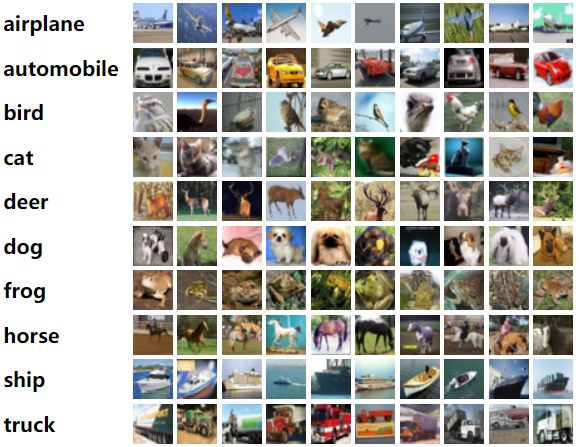


We transform the data into a tensor before nomalizing it.

In [41]:
## Getting Data:

transform = transforms.Compose([transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        transform=transform, download = True)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=8,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       transform=transform, download = True)

testloader = torch.utils.data.DataLoader(testset, batch_size=8,
                                         shuffle=False, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


## 2.2 Accuracy Calcultor: 

In [42]:
def AccuracyCalculator(model):
    ##Testing:
    testing_time = time.time()
    correct = 0
    total = 0
    with torch.no_grad(): 
        for data in testloader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print('Accuracy : %d %%' % (
        100 * correct / total))
    testing_time = time.time() - testing_time
    return 100 * correct / total, testing_time

## 2.2 - Training:
We first use a generic trainer for our model. 

In [43]:
def model_trainer(model, loss_fct, optimizer_fct, epoch = 20, lr = 0.001, momentum = 0.9):
    model_losses = [] ##register  epoch & loss
    optimizer = optim.SGD(model.parameters(), lr, momentum)
    train_time_model = time.time()

    for ep in range(epoch):  

        running_loss = 0.0

        for i, data in enumerate(trainloader, 0):

            inputs, labels = data  
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)        

            loss = loss_fct(outputs, labels)
            loss.backward()

            optimizer.step()

            running_loss += loss.item()
        model_losses +=[[ep+1, running_loss / 6250]] 
        print('epoch : %d , loss = %.3f' % (ep+1, running_loss / 6250))

        if (running_loss / 6250) < 0.05:
            break
    train_time_model = time.time() - train_time_model
    return train_time_model

In [44]:
loss_fct = nn.CrossEntropyLoss()
optimizer_fct = optim.SGD

In [45]:
## Model:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        
name = "small"
rho = 1
res = int(rho * 224)

MBNV3Net_regular = MobileNetV3(name, classes = 10)
MBNV3Net_regular = MBNV3Net_regular.to(device)



cuda


In [60]:
model_trainer(MBNV3Net_regular, loss_fct, optimizer_fct, epoch = 25)
torch.save(MBNV3Net_regular.state_dict(), "MobileNetV3_regular.pt")

epoch : 1 , loss = 0.168
epoch : 2 , loss = 0.169
epoch : 3 , loss = 0.171
epoch : 4 , loss = 0.165
epoch : 5 , loss = 0.168
epoch : 6 , loss = 0.166
epoch : 7 , loss = 0.166
epoch : 8 , loss = 0.165
epoch : 9 , loss = 0.167
epoch : 10 , loss = 0.167
epoch : 11 , loss = 0.164
epoch : 12 , loss = 0.162
epoch : 13 , loss = 0.159
epoch : 14 , loss = 0.157
epoch : 15 , loss = 0.160
epoch : 16 , loss = 0.163
epoch : 17 , loss = 0.166
epoch : 18 , loss = 0.162
epoch : 19 , loss = 0.158
epoch : 20 , loss = 0.158
epoch : 21 , loss = 0.155
epoch : 22 , loss = 0.156
epoch : 23 , loss = 0.155
epoch : 24 , loss = 0.156
epoch : 25 , loss = 0.159


In [62]:
torch.save(MBNV3Net_regular.state_dict(), "MobileNetV3_regular.pt")

In [89]:
AccuracyCalculator(MBNV3Net_regular)

Accuracy : 73 %


(73.48, 8.187169313430786)

## 2.3 - Robustness :
We now explore the robustness of our model. We will first create an Adverse example Attack to see how our model reacts to it.

We perturb the input image slightly to see how our model react to it: 


$$
Perturbed\_image \ =\ image\ + \epsilon*sign(\nabla_x J(\theta, x, y))
$$

### 2.3.1 - FGSM Attack:
We follow the Pytorch FGSM attack:

In [63]:
def fgsm_attack(image, epsilon, data_grad):
    # Collect the element-wise sign of the data gradient
    sign_data_grad = data_grad.sign()
    # Create the perturbed image by adjusting each pixel of the input image
    perturbed_image = image + epsilon*sign_data_grad
    # Adding clipping to maintain [0,1] range
    perturbed_image = torch.clamp(perturbed_image, 0, 1)
    # Return the perturbed image
    return perturbed_image

### 2.3.2 - Testing Function:

We use the pytorch testing function that apply the fgsm attack to the testing set and computes the model's accuracy.

In [87]:
def test( model, device, test_loader, epsilon ):

    # Accuracy counter
    correct = 0
    adv_examples = []
    model.eval()
    # Loop over all examples in test set
    for data, target in test_loader:

        # Send the data and label to the device
        data, target = data.to(device), target.to(device)

        # Set requires_grad attribute of tensor. Important for Attack
        data.requires_grad = True

        # Forward pass the data through the model
        output = model(data)
        init_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability

        # If the initial prediction is wrong, dont bother attacking, just move on
        if init_pred.item() != target.item():
            continue

        # Calculate the loss
        loss = F.nll_loss(output, target)

        # Zero all existing gradients
        model.zero_grad()

        # Calculate gradients of model in backward pass
        loss.backward()

        # Collect datagrad
        data_grad = data.grad.data

        # Call FGSM Attack
        perturbed_data = fgsm_attack(data, epsilon, data_grad)

        # Re-classify the perturbed image
        output = model(perturbed_data)

        # Check for success
        final_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
        if final_pred.item() == target.item():
            correct += 1
            # Special case for saving 0 epsilon examples
            if (epsilon == 0) and (len(adv_examples) < 5):
                adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )
        else:
            # Save some adv examples for visualization later
            if len(adv_examples) < 5:
                adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )

    # Calculate final accuracy for this epsilon
    final_acc = correct/float(len(test_loader))
    print("Epsilon: {}\tTest Accuracy = {} / {} = {}".format(epsilon, correct, len(test_loader), final_acc))

    # Return the accuracy and an adversarial example
    return final_acc, adv_examples

### 2.3.3 -  Running The Attack:

In [90]:
accuracies = []
examples = []
epsilons = [0.05, 0.1, 0.5]
print(epsilons)
# Run test for each epsilon
test_loader = torch.utils.data.DataLoader(testset, batch_size=1,
                                         shuffle=False, num_workers=2)
for eps in epsilons:
    acc, ex = test(MBNV3Net_regular, device, test_loader, eps)
    accuracies.append(acc)
    examples.append(ex)

[0.05, 0.1, 0.5]
Epsilon: 0.05	Test Accuracy = 1129 / 10000 = 0.1129
Epsilon: 0.1	Test Accuracy = 700 / 10000 = 0.07
Epsilon: 0.5	Test Accuracy = 447 / 10000 = 0.0447


### 2.3.4 - Results :

The Model is heavily affected by adverse example Attack which is rather worrisome. 

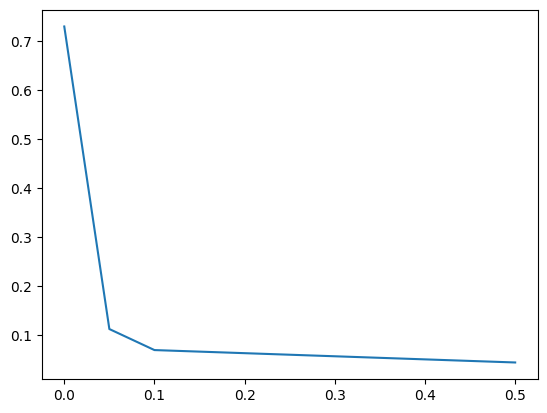

In [91]:
plt.plot([0,0.05,0.1,0.5], [0.73, 0.1129, 0.07, 0.0447])
plt.xlabel('epsilon')
plt.ylabel('accuracy')
plt.title('Model Accuracy After running Adverse Example Attack')

One possible way to solve this problem is to incorporate the Adverse examples in the training. While computationally heavy, a second solution would be to look at robustness as a factor in the Neural Architecture Search producing the most robust model.